In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode, quote
import json, io

%matplotlib inline

In [2]:
sns.set(
    font_scale=2,
    style='whitegrid',
    rc={'figure.figsize': (20, 7)}
)

In [3]:
def get_ydisc_public_data_csv(file_url: 'str') -> pd.DataFrame():
    """
    Скачивает данные по публичной ссылке из Яндекс Диска и заносит их в DataFrame
    """
    base = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    url = base + urlencode(dict(public_key=file_url))
    response = requests.get(url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    data = pd.read_csv(io.BytesIO(download_response.content))
    return data
    

In [4]:
url_customers_disc = 'https://disk.yandex.ru/d/FUi5uSd6BfG_ig'

In [5]:
url_orders_disc= 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg'

In [6]:
url_ord_items_disc = 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'

In [7]:
'''
customer_id — позаказный идентификатор пользователя
customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
customer_zip_code_prefix —  почтовый индекс пользователя
customer_city —  город доставки пользователя
customer_state —  штат доставки пользователя
'''
customers = get_ydisc_public_data_csv(url_customers_disc)

In [8]:
'''
order_id —  уникальный идентификатор заказа (номер чека)
customer_id —  позаказный идентификатор пользователя
order_status —  статус заказа
order_purchase_timestamp —  время создания заказа
order_approved_at —  время подтверждения оплаты заказа
order_delivered_carrier_date —  время передачи заказа в логистическую службу
order_delivered_customer_date —  время доставки заказа
order_estimated_delivery_date —  обещанная дата доставки
'''
orders = get_ydisc_public_data_csv(url_orders_disc)

In [9]:
'''
order_id —  уникальный идентификатор заказа (номер чека)
order_item_id —  идентификатор товара внутри одного заказа
product_id —  ид товара (аналог штрихкода)
seller_id — ид производителя товара
shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
price —  цена за единицу товара
freight_value —  вес товара
'''
order_items = get_ydisc_public_data_csv(url_ord_items_disc)

### Предварительное исследование и предобработка данных

In [10]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [11]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [12]:
customers.shape

(99441, 5)

In [13]:
customers.customer_id.nunique()

99441

In [14]:
# Сразу очевидно, что большинство пользователей покупали только один раз
customers.customer_unique_id.nunique()

96096

In [15]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [16]:
# Переводим в datetime64[ns]
for column in orders.columns[3:]:
    orders[column] = pd.to_datetime(orders[column])

In [17]:
order_items['shipping_limit_date'] = pd.to_datetime(order_items.shipping_limit_date)

In [18]:
first = orders.order_approved_at.min()

In [19]:
last = orders.order_approved_at.max()

In [20]:
order_items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [21]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

### 1. Сколько у нас пользователей, которые совершили покупку только один раз? 
***
Исходя из идеи, что не стоит принимать категорию *delivered* товаров как однозначно купленных, так как существует возможность брака\отказа, стоит принять за покупку - момент внесения оплаты. (**order_approved_at** column)

In [22]:
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [23]:
# Выбираем статусы, которые нас удовлетворяют
payment_status = ['delivered', 'shipped', 'processing', 'approved']

In [24]:
# Фильтруем данные по этим статусам
orders_with_approved_status = orders.query('order_status in @payment_status')\
    [['order_id', 'customer_id', 'order_approved_at', 'order_status']]\
    .set_index('order_id')
orders_with_approved_status

,customer_id,order_approved_at,order_status
order_id,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,delivered
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,delivered
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23,delivered
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59,delivered
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,delivered
...,...,...,...
9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,delivered
63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 13:10:37,delivered
83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 15:04:16,delivered


In [25]:
# Преобразуем таблицу с заказчиками для последующего join
customer_cust_uniq = customers[['customer_id', 'customer_unique_id']].set_index('customer_id')

In [26]:
join_groups = orders_with_approved_status.join(customer_cust_uniq, on='customer_id')


In [27]:
# Count не учитывает значения c NaN (Присваивает таким 0 в агрегации)
(join_groups.groupby('customer_unique_id')\
    .agg(total=('order_approved_at', 'count'))['total']==1).sum()

91804

In [28]:
# Что интересно, наблюдаем такие доставленные товары, у которых отсутствует подтверждение оплаты заказа.
# Возможен баг, оставим их неучтенными
join_groups[join_groups.order_approved_at.isna()]

,customer_id,order_approved_at,order_status,customer_unique_id
order_id,,,,
e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,NaT,delivered,8a9a08c7ca8900a200d83cf838a07e0b
8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,NaT,delivered,91efb7fcabc17925099dced52435837f
7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,NaT,delivered,e1f01a1bd6485e58ad3c769a5427d8a8
5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,NaT,delivered,7e1a5ca61b572d76b64b6688b9f96473
12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,NaT,delivered,c8822fce1d0bfa7ddf0da24fff947172
c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,NaT,delivered,6ff8b0d7b35d5c945633b8d60165691b
d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,NaT,delivered,2e0a2166aa23da2472c6a60c4af6f7a6
d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,NaT,delivered,c4c0011e639bdbcf26059ddc38bd3c18
7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,NaT,delivered,d49f3dae6bad25d05160fc17aca5942d


*Совершили покупку один раз: **91804** пользователей*

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам? 

In [29]:
# Выбираем интересующие статусы. Возьмем за основу, что значение order_delivered_customer_date должно быть NaT
orders_canceled_status = [ 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved']

In [30]:
filt1 = orders.order_delivered_customer_date.isna()
filt2 = orders.order_status.isin(orders_canceled_status)

In [31]:
canceled_orders = orders[filt1 & filt2]
canceled_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [32]:
canceled_orders['order_date'] = canceled_orders.order_purchase_timestamp.dt.to_period('M')
canceled_orders.head(2)

<ipython-input-32-fd4e1f3efd80>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canceled_orders['order_date'] = canceled_orders.order_purchase_timestamp.dt.to_period('M')


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,2017-04
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-06


In [33]:
canceled_group_order_month = \
    canceled_orders.groupby(['order_date', 'order_status'], as_index=False)\
    .agg(canceled_order_count=('order_id', 'count'))

In [34]:
pivot_canceled = canceled_group_order_month\
    .pivot_table(index='order_date', columns='order_status', values='canceled_order_count')\
    .fillna(0)
pivot_canceled.head(5)

order_status,approved,canceled,created,invoiced,processing,shipped,unavailable
order_date,,,,,,,
2016-09,0.0,2.0,0.0,0.0,0.0,1.0,0.0
2016-10,0.0,19.0,0.0,18.0,2.0,8.0,7.0
2017-01,0.0,3.0,0.0,12.0,9.0,16.0,10.0
2017-02,1.0,17.0,0.0,11.0,32.0,21.0,45.0
2017-03,0.0,33.0,0.0,3.0,23.0,45.0,32.0


In [35]:
for reason in pivot_canceled.columns:
    reason_mean = pivot_canceled[reason].mean()
    print(f'Среднее количество не доставленных заказов в месяц по причине {reason}: {round(reason_mean,2)}')

Среднее количество не доставленных заказов в месяц по причине approved: 0.08
Среднее количество не доставленных заказов в месяц по причине canceled: 25.79
Среднее количество не доставленных заказов в месяц по причине created: 0.21
Среднее количество не доставленных заказов в месяц по причине invoiced: 13.08
Среднее количество не доставленных заказов в месяц по причине processing: 12.54
Среднее количество не доставленных заказов в месяц по причине shipped: 46.12
Среднее количество не доставленных заказов в месяц по причине unavailable: 25.38


*Получаем, что из-за отмены заказа (canceled), в среднем в месяц теряем **26** заказов, а из-за (предположительно) недостатка товара на складе или у поставщиков (unavailable) - **25**. Наблюдаем, что у нас очень много заказов, которые уже были отправлены, отгружены, но не были доставлены. Вероятно существует сбой при смене статуса заказа, считаю это багом*. 

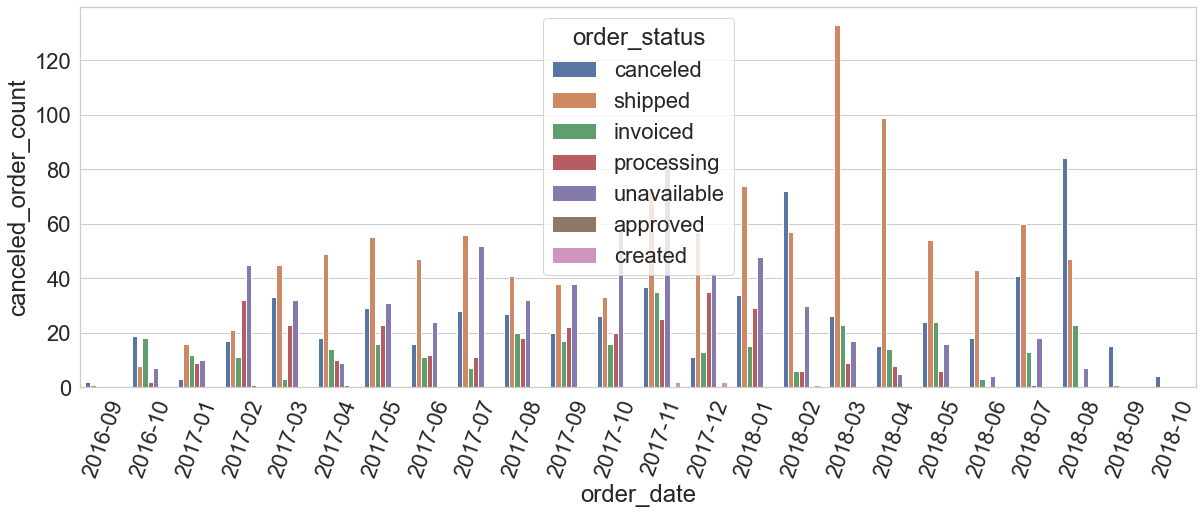

In [36]:
sns.barplot(data=canceled_group_order_month, x='order_date', hue='order_status', y='canceled_order_count')
a = plt.xticks(rotation=70)

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [37]:
# Добавили индекс по которому будем мерджить
# Оставляем только значение product_id в columns
order_product_id = order_items.set_index('order_id')[['product_id']]

In [38]:
# Фильтруем данные по условию подтверждения оплаты заказа
# Добавляем день недели
paid_orders_id = orders[orders.order_approved_at.notna()]
paid_orders_id['day_of_week'] = paid_orders_id.order_approved_at.dt.day_name()
paid_orders_id = paid_orders_id[['order_id', 'day_of_week']]

<ipython-input-38-607993652321>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paid_orders_id['day_of_week'] = paid_orders_id.order_approved_at.dt.day_name()


In [39]:
paid_orders_id.head(3)

,order_id,day_of_week
0,e481f51cbdc54678b7cc49136f2d6af7,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,Thursday
2,47770eb9100c2d0c44946d9cf07ec65d,Wednesday


In [40]:
order_product_id.head(3)

,product_id
order_id,
00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61
00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f
000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd


In [41]:
order_product = paid_orders_id.merge(order_product_id, how='left', on='order_id')

In [42]:
# Для удобства переместим день недели
order_product = order_product[[c for c in order_product if c not in ['day_of_week']] + ['day_of_week']]
order_product.head(3)

,order_id,product_id,day_of_week
0,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,595fac2a385ac33a80bd5114aec74eb8,Thursday
2,47770eb9100c2d0c44946d9cf07ec65d,aa4383b373c6aca5d8797843e5594415,Wednesday


In [43]:
# def most_common(series):
#     lst = list(series)
#     return max(set(lst), key=lst.count)

In [44]:
# Другой способ, но очень ресурсоёмкий
# %timeit order_product.groupby('product_id', as_index=False)\
#     .agg({'day_of_week': lambda series: max(set(series), key=list(series).count)})



In [45]:
 order_product.groupby(['product_id', 'day_of_week'], as_index=False)\
    .agg(quantity=('order_id', 'count')).sort_values('quantity', ascending=False)\
    .drop_duplicates(subset=['product_id'], keep='first')\
    .rename(columns={'day_of_week': 'most_common_order_day'})


,product_id,most_common_order_day,quantity
41082,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
20152,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
15933,422879e10f46682990de24d770e7f83d,Tuesday,89
36574,99a4788cb24856965c36a24e339b6058,Tuesday,82
13060,368c6c730842d78016ad823897a372db,Thursday,80
...,...,...,...
23976,63dfa8b12200610ed7b5e41d3c888a25,Saturday,1
23980,63e51e65ec59b56039c6427eed73dcf0,Tuesday,1
23981,63eb97106bfe47fe857edcf78f3e3e08,Saturday,1
23991,63f52009dc3ddb733394e80183aed0f0,Saturday,1


*Получили id продукта вместе с его самым популярным **днем** заказа и с **максимальным** количеством заказов в этот день недели*

### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

In [ ]:
# Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели

In [46]:
# Используем df полученный на первом шаге, убирая те, предполагаемо, забагованные заказы (доставленные, но не оплаченные)
paid_orders = join_groups[join_groups.order_approved_at.notna()]\
    .assign(order_date=join_groups.order_approved_at.dt.to_period('M'))\
    [['customer_unique_id', 'order_status', 'order_date']]

In [47]:
paid_orders.head(2)

,customer_unique_id,order_status,order_date
order_id,,,
e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10
53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,delivered,2018-07


In [48]:
# Добавили значение среднего количества недель в месяце каждого заказа
paid_orders_4 = paid_orders.assign(week_per_month=paid_orders.order_date.dt.days_in_month / 7)


In [49]:
paid_orders_4.head(2)

,customer_unique_id,order_status,order_date,week_per_month
order_id,,,,
e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10,4.428571
53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,delivered,2018-07,4.428571


In [50]:
# Группируем по уникальному юзеру и его месяцу оплаты (Если пользователь оставил несколько заказов в один месяц)
# Значение среднего по месяцам не должно меняться, берем первое 
paid_orders_4 = paid_orders_4.groupby(['customer_unique_id', 'order_date'], as_index=False)\
    .agg({'order_status': 'count', 'week_per_month': lambda x: x.iloc[0]})
paid_orders_4 = paid_orders_4.rename(columns={'order_status': 'quantity'})
paid_orders_4.head(2)

,customer_unique_id,order_date,quantity,week_per_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.428571
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.428571


In [51]:
# Считаем среднее количество заказов в неделю у каждого пользователя за каждый месяц раздельно. 
paid_orders_4['order_per_week'] = paid_orders_4.quantity / paid_orders_4.week_per_month


In [52]:
# Теперь схлопываем каждого пользователя, находя средние значение заказов в неделю из всех его "средних" в разные месяца.
paid_orders_4 = paid_orders_4.groupby('customer_unique_id', as_index=False).agg({'order_per_week': 'mean'})
paid_orders_4.head(5)

,customer_unique_id,order_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.225806
2,0000f46a3911fa3c0805444483337064,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,0.225806
4,0004aac84e0df4da2b147fca70cf8255,0.233333


### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

Формируем кагорты на основе даты первой оплаты.

In [53]:
min_date, max_date = pd.Series(['2017-01', '2018-03']).astype('period[M]')
min_date, max_date

(Period('2017-01', 'M'), Period('2018-03', 'M'))

In [54]:
# Заказы, у которых подтверждена оплата и находятся в пределах 2017-01 до 2018-03 (т.к 2017-12 + 3 месяца)
filt = paid_orders['order_date'].between(min_date, max_date)

In [55]:
# Заказы с 2017-01-01 по 2018-02-28
paid_orders_5 = paid_orders[filt].reset_index()[['customer_unique_id', 'order_date']]
paid_orders_5

,customer_unique_id,order_date
0,7c396fd4830fd04220f754e42b4e5bff,2017-10
1,7c142cf63193a1473d2e66489a9ae977,2017-11
2,72632f0f9dd73dfee390c9b22eb56dd6,2018-02
3,80bb27c7c16e8f973207a5086ab329e2,2017-07
4,932afa1e708222e5821dac9cd5db4cae,2017-05
...,...,...
65041,6359f309b166b0196dbf7ad2ac62bb5a,2017-03
65042,da62f9e57a76d978d02ab5362c509660,2018-02
65043,737520a9aad80b3fbbdad19b66b37b30,2017-08
65044,5097a5312c8b157bb7be58ae360ef43c,2018-01


In [56]:
# Для проверки позже, количество уникальных польователей
paid_orders_5.customer_unique_id.nunique()

62979

In [57]:
# # Убрали дубликаты
paid_orders_5 = paid_orders_5.drop_duplicates()

In [59]:
# Оставили у каждого покупателя дату его первой покупки и ожидаемую дату возвращения для расчета retention за 3 месяца
cohort_date = paid_orders_5.groupby('customer_unique_id').agg(first_order=('order_date','min'))
cohort_date['cahort_3_month_date']=cohort_date.first_order + 3

In [60]:
# Количество уникальных пользователей совпадает
cohort_date

,first_order,cahort_3_month_date
customer_unique_id,,
0000f46a3911fa3c0805444483337064,2017-03,2017-06
0000f6ccb0745a6a4b88665a16c9f078,2017-10,2018-01
0004aac84e0df4da2b147fca70cf8255,2017-11,2018-02
00053a61a98854899e70ed204dd4bafe,2018-02,2018-05
0005e1862207bf6ccc02e4228effd9a0,2017-03,2017-06
...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,2017-12,2018-03
fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,2017-09
fffea47cd6d3cc0a88bd621562a9d061,2017-12,2018-03


In [61]:
# Соединили со всеми данными
paid_orders_5 = paid_orders_5.join(cohort_date, on='customer_unique_id')
paid_orders_5

,customer_unique_id,order_date,first_order,cahort_3_month_date
0,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09,2017-12
1,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11,2018-02
2,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,2018-02,2018-05
3,80bb27c7c16e8f973207a5086ab329e2,2017-07,2017-07,2017-10
4,932afa1e708222e5821dac9cd5db4cae,2017-05,2017-05,2017-08
...,...,...,...,...
65041,6359f309b166b0196dbf7ad2ac62bb5a,2017-03,2017-03,2017-06
65042,da62f9e57a76d978d02ab5362c509660,2018-02,2018-02,2018-05
65043,737520a9aad80b3fbbdad19b66b37b30,2017-08,2017-08,2017-11
65044,5097a5312c8b157bb7be58ae360ef43c,2018-01,2018-01,2018-04


**Первый способ** *Считаем Rolling Retention (RR)*

In [62]:
paid_orders_5_new = paid_orders_5.copy()

In [63]:
# Создаем словарь и присваиваем каждому месяцу заказов последовательно номер кагорты
cohort_month = dict(zip(sorted(paid_orders_5_new.order_date.unique()), range(1, 16)))

In [64]:
# month - номер месяца в заказе, cohort - номер месяца первого заказа
paid_orders_5_new['month'] = paid_orders_5_new.order_date.apply(lambda x: cohort_month[x])
paid_orders_5_new['cohort'] = paid_orders_5_new.first_order.apply(lambda x: cohort_month[x])

In [65]:
paid_orders_5_new = paid_orders_5_new.drop(['order_date', 'first_order', 'cahort_3_month_date'], axis=1)

In [66]:
# Здесь мы видим польщователя, который сделал заказ, в каком месяце он сделал и к какой кагорте принадлежит
paid_orders_5_new.head()

,customer_unique_id,month,cohort
0,7c396fd4830fd04220f754e42b4e5bff,10,9
1,7c142cf63193a1473d2e66489a9ae977,11,11
2,72632f0f9dd73dfee390c9b22eb56dd6,14,14
3,80bb27c7c16e8f973207a5086ab329e2,7,7
4,932afa1e708222e5821dac9cd5db4cae,5,5


In [67]:
cohort_new = paid_orders_5_new.groupby(['cohort', 'month'], as_index=False).agg({'customer_unique_id': 'nunique'})
cohort_new['period'] = cohort_new['month'] - cohort_new['cohort']
cohort_new.head()

,cohort,month,customer_unique_id,period
0,1,1,706,0
1,1,2,4,1
2,1,3,2,2
3,1,4,1,3
4,1,5,3,4


In [68]:
cohort_new = cohort_new.pivot(index='cohort', columns='period', values='customer_unique_id').fillna(0)

In [69]:
cohort_new

period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cohort,,,,,,,,,,,,,,,
1,706.0,4.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,0.0,2.0,2.0,5.0,3.0,1.0
2,1662.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0,3.0,0.0
3,2577.0,13.0,9.0,9.0,9.0,4.0,4.0,8.0,8.0,3.0,9.0,3.0,6.0,0.0,0.0
4,2288.0,14.0,5.0,4.0,6.0,6.0,8.0,6.0,8.0,4.0,5.0,2.0,0.0,0.0,0.0
5,3527.0,19.0,17.0,14.0,11.0,12.0,15.0,5.0,9.0,9.0,10.0,0.0,0.0,0.0,0.0
6,3102.0,14.0,11.0,12.0,8.0,10.0,11.0,7.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0
7,3771.0,20.0,12.0,7.0,13.0,7.0,12.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4136.0,28.0,15.0,11.0,16.0,22.0,11.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,4083.0,27.0,20.0,14.0,17.0,11.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
cohort_size = cohort_new.iloc[0:,0]

In [71]:
# Делим каждое значение периода на размер кагорты
# Слева номер кагорты, сверху период в месяцах
cohort_new.divide((cohort_size / 100).round(2), axis=0)

period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cohort,,,,,,,,,,,,,,,
1,100.0,0.566572,0.283286,0.141643,0.424929,0.141643,0.424929,0.141643,0.141643,0.000000,0.283286,0.283286,0.708215,0.424929,0.141643
2,100.0,0.240674,0.240674,0.180505,0.421179,0.120337,0.240674,0.180505,0.060168,0.180505,0.120337,0.300842,0.120337,0.180505,0.000000
3,100.0,0.504463,0.349243,0.349243,0.349243,0.155219,0.155219,0.310438,0.310438,0.116414,0.349243,0.116414,0.232829,0.000000,0.000000
4,100.0,0.611888,0.218531,0.174825,0.262238,0.262238,0.349650,0.262238,0.349650,0.174825,0.218531,0.087413,0.000000,0.000000,0.000000
5,100.0,0.538701,0.481996,0.396938,0.311880,0.340232,0.425291,0.141764,0.255174,0.255174,0.283527,0.000000,0.000000,0.000000,0.000000
6,100.0,0.451322,0.354610,0.386847,0.257898,0.322373,0.354610,0.225661,0.128949,0.225661,0.000000,0.000000,0.000000,0.000000,0.000000
7,100.0,0.530363,0.318218,0.185627,0.344736,0.185627,0.318218,0.106073,0.185627,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,100.0,0.676983,0.362669,0.265957,0.386847,0.531915,0.265957,0.265957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,100.0,0.661278,0.489836,0.342885,0.416361,0.269410,0.220426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


*Самый высокий retention за 3 месяца проявился у **5** и **6** когорты*. 0.396938 и 0.386847 Разумеется это очень маленькое значение. 

**Второй способ**

In [72]:
# Проверяем совпадает ли дата заказа с ожидаемой датой retention
paid_orders_5['comeback_after_3_month'] = paid_orders_5.cahort_3_month_date == paid_orders_5.order_date
paid_orders_5.head()

,customer_unique_id,order_date,first_order,cahort_3_month_date,comeback_after_3_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09,2017-12,False
1,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11,2018-02,False
2,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,2018-02,2018-05,False
3,80bb27c7c16e8f973207a5086ab329e2,2017-07,2017-07,2017-10,False
4,932afa1e708222e5821dac9cd5db4cae,2017-05,2017-05,2017-08,False


In [73]:
# Группируем по дате первой покупки. Считаем количество уникальных клиентов и количество вернувшихся через 3 месяца.
# Убираем последние 3 месяца, так как для них нет статистики
retention = paid_orders_5.groupby('first_order')\
    .agg({'customer_unique_id': 'count', 'comeback_after_3_month': 'sum'})[:-3]


In [74]:
# Высчитваем процент
retention['retention_percents'] = retention.comeback_after_3_month / retention.customer_unique_id * 100

In [75]:
retention

,customer_unique_id,comeback_after_3_month,retention_percents
first_order,,,
2017-01,735,1,0.136054
2017-02,1705,3,0.175953
2017-03,2662,9,0.338092
2017-04,2356,4,0.169779
2017-05,3648,14,0.383772
2017-06,3186,12,0.376648
2017-07,3853,7,0.181677
2017-08,4250,11,0.258824
2017-09,4181,14,0.334848


<AxesSubplot:xlabel='first_order', ylabel='retention_percents'>

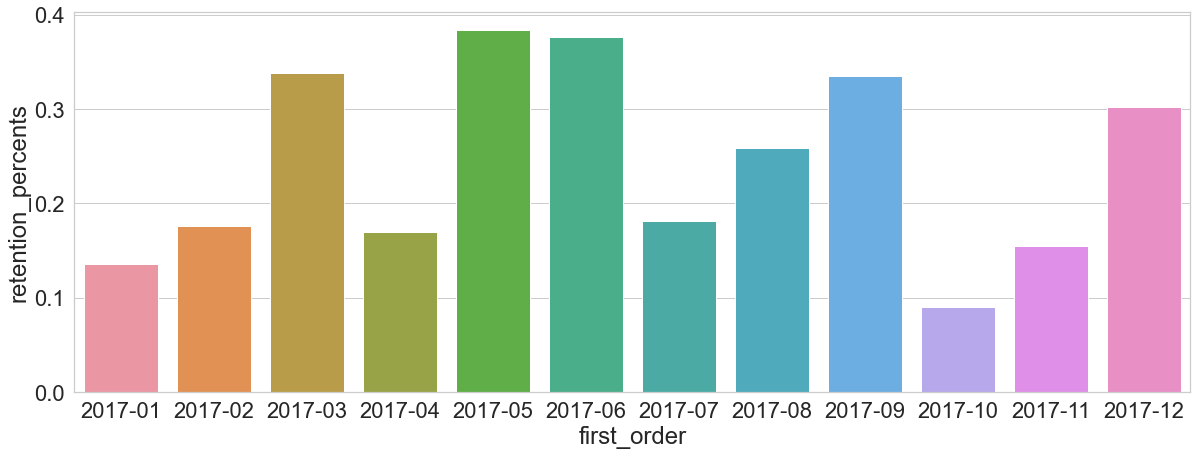

In [76]:
sns.barplot(data=retention, x=retention.index, y='retention_percents')

*Самый высокий retention за 3 месяца проявился у **5** и **6** когорты*

### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

In [280]:
# RFM
# r- как давно последняя покупка 1-4
# f- как часто покупал раннее 1-4
# m- как много денег потратил 1-4 
#  Поставим себе задачу о сегментировании наших клиентов с целью выявить группу лояльных клиентов,для построение модели на отклик,
# а так же менее лояльных для построения модели на отток

In [370]:
paid_orders_6 = join_groups[join_groups.order_approved_at.notna()]\
    .assign(order_date=join_groups.order_approved_at.dt.to_period('M'),
           )

In [371]:
paid_orders_6.head(2)

,customer_id,order_approved_at,order_status,customer_unique_id,order_date
order_id,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,delivered,7c396fd4830fd04220f754e42b4e5bff,2017-10
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,delivered,af07308b275d755c9edb36a90c618231,2018-07


In [372]:
# Смотрим за какое время у нас есть данные, ставим задачу выявить лояльных и нелояльных клиентов на 2018-09
paid_orders_6.order_date.value_counts().sort_index()

2016-09       1
2016-10     276
2016-12       1
2017-01     739
2017-02    1691
2017-03    2623
2017-04    2338
2017-05    3626
2017-06    3203
2017-07    3893
2017-08    4276
2017-09    4231
2017-10    4495
2017-11    7246
2017-12    5768
2018-01    7093
2018-02    6598
2018-03    7226
2018-04    6744
2018-05    7002
2018-06    6139
2018-07    6113
2018-08    6551
2018-09       1
Freq: M, Name: order_date, dtype: int64

In [373]:
# Берем данные с начала года, полагая, что это граница "ролевантности" данных
min_date, max_date = pd.Timestamp('2018-01') , pd.Timestamp('2018-08')

Timestamp('2018-08-01 00:00:00')

In [374]:
paid_orders_6 = paid_orders_6[paid_orders_6.order_approved_at.between(min_date, max_date)]
paid_orders_6.head()

,customer_id,order_approved_at,order_status,customer_unique_id,order_date
order_id,,,,,
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,delivered,af07308b275d755c9edb36a90c618231,2018-07
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,delivered,72632f0f9dd73dfee390c9b22eb56dd6,2018-02
82566a660a982b15fb86e904c8d32918,d3e3b74c766bc6214e0c830b17ee2341,2018-06-09 03:13:12,delivered,e97109680b052ee858d93a539597bba7,2018-06
5ff96c15d0b717ac6ad1f3d77225a350,19402a48fe860416adf93348aba37740,2018-07-25 17:55:14,delivered,e2dfa3127fedbbca9707b36304996dab,2018-07
432aaf21d85167c2c86ec9448c4e42cc,3df704f53d3f1d4818840b34ec672a9f,2018-03-01 15:10:47,delivered,04cf8185c71090d28baa4407b2e6d600,2018-03


In [376]:
# Считаем выручку с каждого заказа
orders_revenue = order_items.groupby('order_id')[['price']].sum()
orders_revenue.head()

,price
order_id,
00010242fe8c5a6d1ba2dd792cb16214,58.90
00018f77f2f0320c557190d7a144bdd3,239.90
000229ec398224ef6ca0657da4fc703e,199.00
00024acbcdf0a6daa1e931b038114c75,12.99
00042b26cf59d7ce69dfabb4e55b4fd9,199.90


In [377]:
paid_orders_6 = paid_orders_6.join(orders_revenue, on='order_id')

In [378]:
paid_orders_6.head()

,customer_id,order_approved_at,order_status,customer_unique_id,order_date,price
order_id,,,,,,
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,delivered,af07308b275d755c9edb36a90c618231,2018-07,118.70
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,delivered,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,19.90
82566a660a982b15fb86e904c8d32918,d3e3b74c766bc6214e0c830b17ee2341,2018-06-09 03:13:12,delivered,e97109680b052ee858d93a539597bba7,2018-06,31.90
5ff96c15d0b717ac6ad1f3d77225a350,19402a48fe860416adf93348aba37740,2018-07-25 17:55:14,delivered,e2dfa3127fedbbca9707b36304996dab,2018-07,19.90
432aaf21d85167c2c86ec9448c4e42cc,3df704f53d3f1d4818840b34ec672a9f,2018-03-01 15:10:47,delivered,04cf8185c71090d28baa4407b2e6d600,2018-03,38.25


In [379]:
# Находим минимальную дату активности за период, максимальную, суммируем выручку по всем заказам, группируя по уникальным id
paid_orders_6 = paid_orders_6.groupby('customer_unique_id').agg(
    reg_date=('order_approved_at','min'),
    last_order=('order_approved_at', 'max'),
    monetary=('price', 'sum'),
    frequency=('order_approved_at', 'count'),
)


In [380]:
# Добавляем месяц от которого будем считать разницу для recency 
paid_orders_6['month'] = pd.Timestamp('2018-09-01')
paid_orders_6['recency'] = paid_orders_6.month - paid_orders_6.last_order

In [382]:
paid_orders_6.head()

,reg_date,last_order,monetary,frequency,month,recency
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,2018-05-10 11:11:18,129.90,1,2018-09-01,113 days 12:48:42
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,2018-05-07 18:25:44,18.90,1,2018-09-01,116 days 05:34:16
0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:48:59,2018-04-05 19:48:59,154.00,1,2018-09-01,148 days 04:11:01
00050ab1314c0e55a6ca13cf7181fecf,2018-04-25 03:51:13,2018-04-25 03:51:13,27.99,1,2018-09-01,128 days 20:08:47
00053a61a98854899e70ed204dd4bafe,2018-02-28 11:32:42,2018-02-28 11:32:42,382.00,1,2018-09-01,184 days 12:27:18


In [384]:
paid_orders_6['r'] = 5 - (pd.qcut(paid_orders_6.recency, 4, labels=False) + 1)

In [386]:
# Разделили данные на 4 группы по дате последней покупки. Чем больше r - тем недавней
paid_orders_6.groupby('r')['recency'].agg(['mean', 'count'])

,mean,count
r,,
1,216 days 19:27:56.435347460,11469
2,166 days 14:54:37.269945070,11469
3,116 days 06:53:29.270206644,11469
4,59 days 03:13:07.329293810,11470


In [389]:
# # Разделили данные на 4 группы по выручке. Чем больше m - тем больше денег
paid_orders_6['m'] = pd.qcut(paid_orders_6.monetary, 4, labels=False) + 1
paid_orders_6.groupby('m')['monetary'].agg(['mean', 'count'])

,mean,count
m,,
1,28.860670,11476
2,66.435438,11700
3,119.636803,11258
4,348.937211,11443


In [390]:
# paid_orders_6['f'] = pd.qcut(paid_orders_6.frequency, 4, labels=False, duplicates='drop') + 1

In [391]:
# paid_orders_6.groupby('f')['frequency'].agg(['mean', 'count'])

In [392]:
# Так как у нас большинство заказов сделанны пользователями впервые, то невозможно разделить ее без совпадения по значению
# Разделяем на 2 группы: 1 если сделал 1 заказ, 3 - если больше 
paid_orders_6['f'] = paid_orders_6.frequency.apply(lambda x: 1 if x==1 else 3)

In [396]:
# Считаем rfm - score и нормализуем его 
paid_orders_6['rfm_score'] = ((paid_orders_6.r + paid_orders_6.f + paid_orders_6.m) / 3).round(2)

In [397]:
paid_orders_6.sort_values('rfm_score', ascending=False)

,reg_date,last_order,monetary,frequency,month,recency,r,f,m,rfm_score
customer_unique_id,,,,,,,,,,
9689908caf4de73724feed92175d867a,2018-02-22 09:35:38,2018-07-31 08:10:17,159.98,2,2018-09-01,31 days 15:49:43,4,3,4,3.67
41b4af321ed477242aebe74652fd8219,2018-05-13 21:52:27,2018-06-11 21:40:22,177.60,2,2018-09-01,81 days 02:19:38,4,3,4,3.67
03ef7f03905227e15c7b6c860554b3cb,2018-05-03 04:15:15,2018-07-18 13:21:55,191.99,2,2018-09-01,44 days 10:38:05,4,3,4,3.67
f74a075d2c4f68917c7d568df06b1e90,2018-07-23 11:31:23,2018-07-24 21:24:30,297.90,2,2018-09-01,38 days 02:35:30,4,3,4,3.67
d970a2354b55cfb67fa5840b9b4936ed,2018-03-06 12:56:01,2018-07-29 18:30:32,215.00,2,2018-09-01,33 days 05:29:28,4,3,4,3.67
...,...,...,...,...,...,...,...,...,...,...
41061f90a640a682d5b590cc99772bec,2018-01-16 12:26:04,2018-01-16 12:26:04,27.99,1,2018-09-01,227 days 11:33:56,1,1,1,1.00
76ea9fe72e101e5bc0941956563f0e38,2018-02-17 11:47:25,2018-02-17 11:47:25,27.99,1,2018-09-01,195 days 12:12:35,1,1,1,1.00
4111110fc42eaa561fb60f2ec72462b6,2018-01-10 10:32:30,2018-01-10 10:32:30,39.90,1,2018-09-01,233 days 13:27:30,1,1,1,1.00


In [400]:
# Сверху получаем наивысший rfm самых лояльных покупателей, снизу - самые неактивные 
paid_orders_6.rfm_score.value_counts().sort_index(ascending=False)

3.67      171
3.33      225
3.00     2945
2.67     5794
2.33     8577
2.00    10949
1.67     8316
1.33     5930
1.00     2970
Name: rfm_score, dtype: int64

In [401]:
# Самые лояльные клиенты, если их можно такими назвать, конечно
paid_orders_6[paid_orders_6.rfm_score > 2.9]

,reg_date,last_order,monetary,frequency,month,recency,r,f,m,rfm_score
customer_unique_id,,,,,,,,,,
000fbf0473c10fc1ab6f8d2d286ce20c,2018-07-27 02:05:20,2018-07-27 02:05:20,285.80,1,2018-09-01,35 days 21:54:40,4,1,4,3.0
0025795df7a7d077c4c90162fa820085,2018-07-25 08:05:12,2018-07-25 08:05:12,177.90,1,2018-09-01,37 days 15:54:48,4,1,4,3.0
003162bf0351f47a1a247992b8b9b42d,2018-07-14 15:55:16,2018-07-14 15:55:16,514.90,1,2018-09-01,48 days 08:04:44,4,1,4,3.0
0033f4a2887e07e25aa1204d482f41ba,2018-06-27 08:12:02,2018-06-27 08:12:02,350.00,1,2018-09-01,65 days 15:47:58,4,1,4,3.0
00344274804f3b8003de1b0562ae01df,2018-07-09 14:24:50,2018-07-09 14:24:50,188.00,1,2018-09-01,53 days 09:35:10,4,1,4,3.0
...,...,...,...,...,...,...,...,...,...,...
ff8eddc3ff272a5724e2ac6635cb7df2,2018-07-01 10:50:13,2018-07-01 10:50:13,926.00,1,2018-09-01,61 days 13:09:47,4,1,4,3.0
ff9d6196f8a9419142b5a70a0dbf469d,2018-06-27 19:15:11,2018-06-27 19:15:11,160.00,1,2018-09-01,65 days 04:44:49,4,1,4,3.0
ffa323b33234124b58b25511035c2855,2018-06-14 17:30:09,2018-06-14 17:30:09,259.00,1,2018-09-01,78 days 06:29:51,4,1,4,3.0


In [404]:
# Те, кого с нами, вероятно, уже нет
paid_orders_6[paid_orders_6.rfm_score < 1.9]

,reg_date,last_order,monetary,frequency,month,recency,r,f,m,rfm_score
customer_unique_id,,,,,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,2018-05-07 18:25:44,18.90,1,2018-09-01,116 days 05:34:16,3,1,1,1.67
00050ab1314c0e55a6ca13cf7181fecf,2018-04-25 03:51:13,2018-04-25 03:51:13,27.99,1,2018-09-01,128 days 20:08:47,3,1,1,1.67
00090324bbad0e9342388303bb71ba0a,2018-03-24 14:55:29,2018-03-24 14:55:29,49.95,1,2018-09-01,160 days 09:04:31,2,1,2,1.67
000d460961d6dbfa3ec6c9f5805769e1,2018-01-07 23:09:21,2018-01-07 23:09:21,28.90,1,2018-09-01,236 days 00:50:39,1,1,1,1.00
000ed48ceeb6f4bf8ad021a10a3c7b43,2018-05-20 16:59:20,2018-05-20 16:59:20,12.88,1,2018-09-01,103 days 07:00:40,3,1,1,1.67
...,...,...,...,...,...,...,...,...,...,...
ffd2e2ad95719ab7fedc9e02c5e26a62,2018-05-18 00:55:34,2018-05-18 00:55:34,29.00,1,2018-09-01,105 days 23:04:26,3,1,1,1.67
ffd402998b20b0b8325f54e770264733,2018-05-31 10:30:46,2018-05-31 10:30:46,13.90,1,2018-09-01,92 days 13:29:14,3,1,1,1.67
ffd6f65402f2bc47238ecd2bdc93e0d4,2018-05-09 21:15:29,2018-05-09 21:15:29,47.00,1,2018-09-01,114 days 02:44:31,3,1,1,1.67
